In [54]:
import numpy as np
from numpy import fft,pi
import scipy.signal
import cPickle as pickle

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import ps_utils_new
import imp
imp.reload(ps_utils_new)
# from plot_styling import dark
import mwa_utils
imp.reload(mwa_utils)

<module 'mwa_utils' from 'mwa_utils.pyc'>

In [55]:
matplotlib.rcParams.update({'font.size': 18})
plt.rc('font', family='Arial')
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False

In [63]:
label_groups = [ \
'02a57694o0299I 02a57694o0303I 02a57694o0307I 02a57694o0319I 02a57694o0323I 02a57694o0327I 02a57694o0339I 02a57694o0343I 02a57694o0347I',\
'02a57694o0298I 02a57694o0302I 02a57694o0306I 02a57694o0318I 02a57694o0322I 02a57694o0326I 02a57694o0338I 02a57694o0342I 02a57694o0346I',\
'02a57694o0301I 02a57694o0305I 02a57694o0309I 02a57694o0321I 02a57694o0325I 02a57694o0329I 02a57694o0341I 02a57694o0345I 02a57694o0349I',\
'02a57694o0300I 02a57694o0304I 02a57694o0308I 02a57694o0320I 02a57694o0324I 02a57694o0328I 02a57694o0340I 02a57694o0344I 02a57694o0348I',\
]
analysis_names = ['_'.join([l.split('o')[1] for l in label_group.split(' ')]) for label_group in label_groups]
print(analysis_names)

['0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I', '0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I', '0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I', '0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I']


In [77]:
# xcor_data_dir = '/home/abrahamn/xcor_data/'
# analysis_root = xcor_data_dir+'analysis/ATLAS_mwa57694_rereduction/'
analysis_dir = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/'
num_frames = len(analysis_names)

ir_images = [pickle.load( open( analysis_dir+a+'_6amin.p', "rb" ) ) for a in analysis_names] # mask artifacts and sources

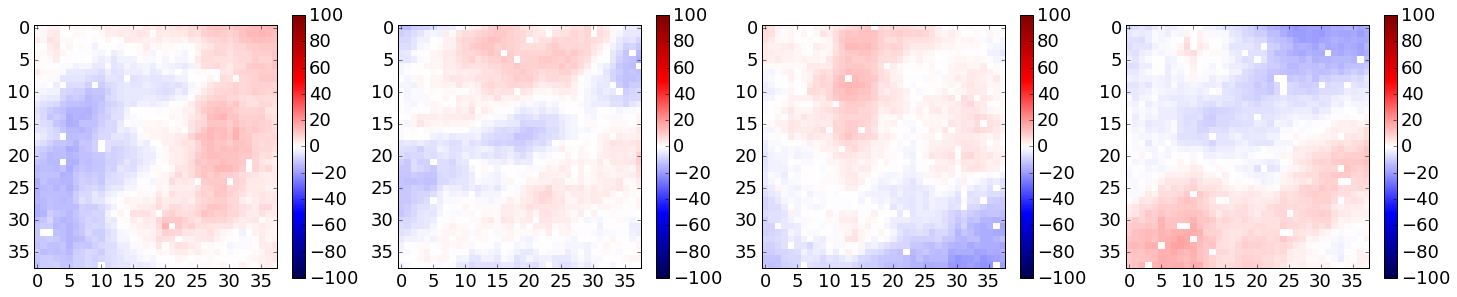

In [78]:
v1=-1.e2
v2=1.e2
cm = 'seismic'

plt.figure(figsize=(25,16))

for framei in range(num_frames):
    imgdat = ir_images[framei]
    img_crop = imgdat['img_kjy_per_sr_crop']
    img_crop[img_crop!=0] -= np.mean(img_crop[img_crop!=0])
    
    plt.subplot(3,num_frames,framei+1)
    plt.imshow(img_crop,interpolation='nearest',cmap=cm,vmin=v1,vmax=v2)
    plt.colorbar()

In [89]:
# load MWA FHD cubes
fhdcubesroot = '/home/abrahamn/xcor_data/fhd_cubes/fhd_apb_EoR0_high_sem1_1/'
fhdlabel = 'Combined_obs_wedge_cut_plus_res_cut'

imp.reload(mwa_utils)
fhddeeplabel = 'Combined_obs_wedge_cut_plus_res_cut'
#freq_averaged_cubedat0,freq_averaged_cubedat1 = mwa_utils.load_freq_averaged_odd_even_cubedat(fhdcubesroot,fhddeeplabel)
pickle.dump([freq_averaged_cubedat0,freq_averaged_cubedat1],open(fhdcubesroot+fhdlabel+'_freq_averaged_cubes_odd_and_even.p','wb'))
#[freq_averaged_cubedat0,freq_averaged_cubedat1] = pickle.load(open(fhdcubesroot+fhdlabel+'_freq_averaged_cubes_odd_and_even.p','rb'))

KeyError: '__getstate__'

In [7]:
# load and uniformly weight MWA images


fov_deg*60/dtheta_amin


dtheta_amin_ir = ir_images[0].dtheta_deg*60
n_full_ir = ir_images[0].n_full
n_frame_ir = ir_images[0].n

imp.reload(mwa_utils)
mwa_images = [mwa_utils.MWAImage(freq_averaged_cubedat0,freq_averaged_cubedat1, dtheta_amin_ir, n_full_ir,\
                                 crop_before_uniform_weighting_params=(n_frame_ir,ir_images[framei].x_med, ir_images[framei].y_med))\
              for framei in range(num_frames)]

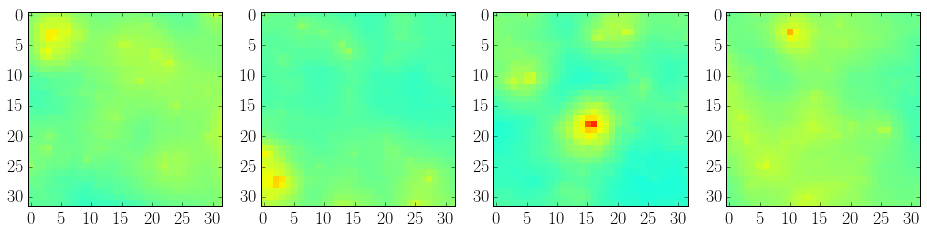

In [24]:
v1,v2 = -1.e7,1.e7
plt.figure(figsize=(16,4))
for i in range(num_frames):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx0,interpolation='nearest',vmin=v1,vmax=v2)

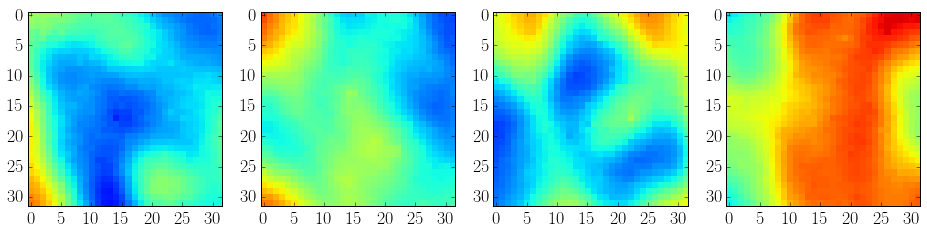

In [25]:
v1,v2 = -1.e6,1.e6
plt.figure(figsize=(16,4))
for i in range(num_frames):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx0-mwa_images[i].model_xx0,interpolation='nearest',vmin=v1,vmax=v2)

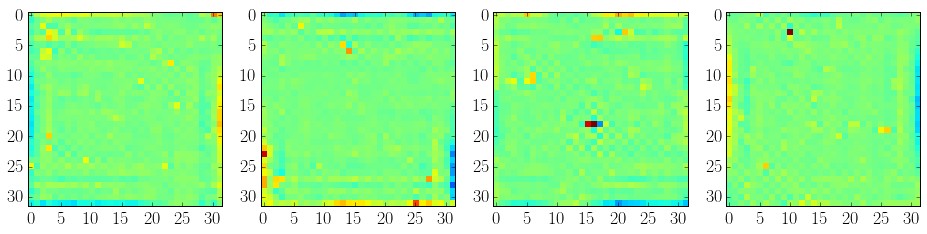

In [26]:
v1,v2 = -500,500
plt.figure(figsize=(16,4))
for i in range(num_frames):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx_u0,interpolation='nearest',vmin=v1,vmax=v2)

(100.0, 3000.0)

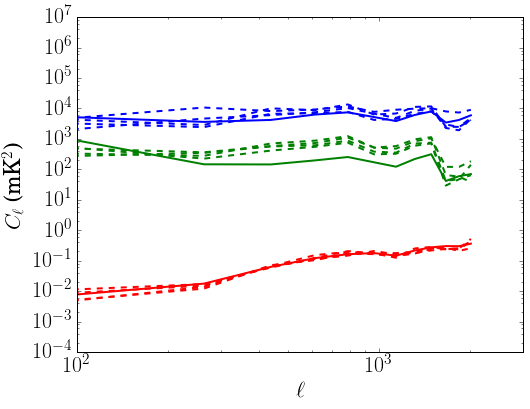

In [27]:
plt.figure(figsize=(8,6))

nbins = 12
lmax = 2100

imp.reload(mwa_utils)
lbincenters, Cl_dirty0, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0, mwa_image_full.weights_xx0, mwa_image_full.dtheta_rad, nbins,lmax, hann=False)
lbincenters, Cl_res0, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0 - mwa_image_full.model_xx_u0, mwa_image_full.weights_xx0,mwa_image_full.dtheta_rad, nbins,lmax, hann=False)
lbincenters, Cl_dirty_diff, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0 - mwa_image_full.dirty_xx_u1, mwa_image_full.weights_xx0,mwa_image_full.dtheta_rad, nbins,lmax, hann=False)

plt.loglog(lbincenters,Cl_dirty0*1.e6,'b-',linewidth=2) # the 1.e6 converts from K to mK
plt.loglog(lbincenters,Cl_res0*1.e6,'g-',linewidth=2)
plt.loglog(lbincenters,Cl_dirty_diff*1.e6,'r-',linewidth=2)

for i in range(num_frames):
    lbincenters_frame, Cl_dirty0_frame, bin_counts_frame, bin_weights_frame = mwa_utils.img2PS(mwa_images[i].dirty_xx_u0, mwa_images[i].weights_xx0, mwa_images[i].dtheta_rad,nbins,lmax,hann=False)
    lbincenters_frame, Cl_res0_frame, bin_counts_frame, bin_weights_frame =     mwa_utils.img2PS(mwa_images[i].dirty_xx_u0 - mwa_images[i].model_xx_u0, mwa_images[i].weights_xx0,mwa_images[i].dtheta_rad, nbins,lmax, hann=False)
    lbincenters_frame, Cl_dirty_diff_frame, bin_counts_frame, bin_weights_frame =  mwa_utils.img2PS(mwa_images[i].dirty_xx_u0 - mwa_images[i].dirty_xx_u1, mwa_images[i].weights_xx0,mwa_images[i].dtheta_rad, nbins,lmax, hann=False)

    plt.loglog(lbincenters_frame,Cl_dirty0_frame*1.e6,'b--',linewidth=2)
    plt.loglog(lbincenters_frame,Cl_res0_frame*1.e6,'g--',linewidth=2)
    plt.loglog(lbincenters_frame,Cl_dirty_diff_frame*1.e6,'r--',linewidth=2)

matplotlib.rcParams.update({'font.size': 22})
plt.ylabel(r'$C_\ell$ (mK$^2$)')
plt.xlabel(r'$\ell$')
plt.ylim([1.e-4,1.e7])
#plt.ylim([10,1.e3])
plt.xlim([1.e2,3.e3])

2180.06087263
2180.06087263
2180.06087263
2180.06087263


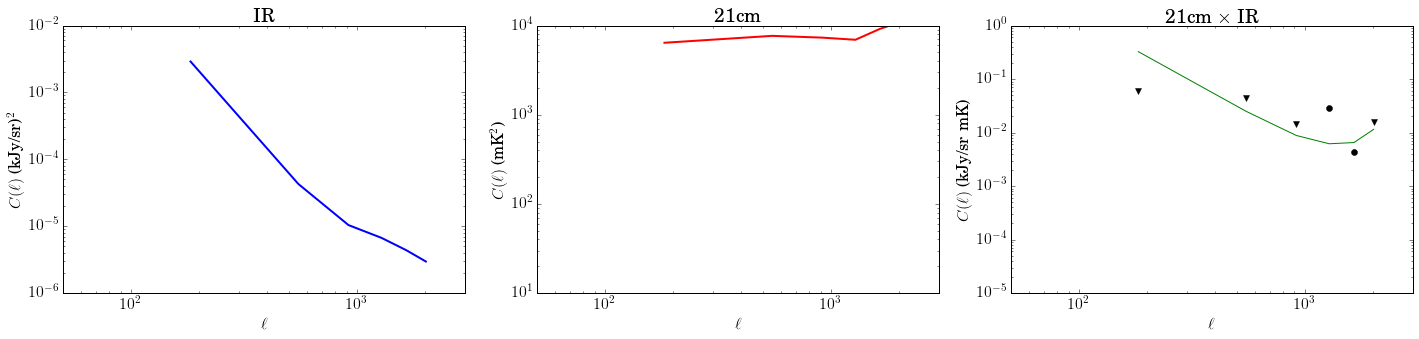

In [62]:
imp.reload(ps_utils_new)
irspecs = []
mwaspecs = []
xspecs = []
for framei in range(num_frames):
    lbins,irspec,mwaspec,xspec,bin_counts,bin_sum_weights,bin_sum_sq_weights = ps_utils_new.ir_and_radio_xspec(ir_images[framei],'',mwa_images[framei],'',nbins=6,lmax=2200,\
                                                                                                                         useirhann=True,usemwahann=True)
    irspecs.append(irspec)
    mwaspecs.append(mwaspec)
    xspecs.append(xspec)
irspecs,mwaspecs,xspecs = np.array(irspecs),np.array(mwaspecs),np.array(xspecs)
irspecs_mean = np.mean(irspecs,axis=0)
mwaspecs_mean = np.mean(mwaspecs,axis=0)
xspecs_mean = np.mean(xspecs,axis=0)


plt.figure(figsize=(20,5))
matplotlib.rcParams.update({'font.size': 16})

x1,x2 = 50,3000

plt.subplot(131)
#plt.loglog(lbins,irspecs[0],'b.-')
plt.loglog(lbins,irspecs_mean,'b-',linewidth=2)
plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (kJy/sr)$^2$')
plt.title('IR')
plt.xlim([x1,x2])
plt.ylim([1.e-6,1.e-2])

plt.subplot(132)
#plt.loglog(lbins,mwaspec,'r.-')
plt.loglog(lbins,mwaspecs_mean*1.e6,'r-',linewidth=2)
# plt.loglog(lbins,Cl_res0*1.e6,'g--')
plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (mK$^2$)')
plt.title('21cm')
plt.xlim([x1,x2])
plt.ylim([10,1.e4])

plt.subplot(133)
# ispos = xspecs[0]>0
# isneg = xspecs[0]<0
# plt.loglog(lbins[ispos],xspecs[0][ispos],'k.')
# plt.loglog(lbins[isneg],-xspecs[0][isneg],'kv')

ispos = xspecs_mean>0
isneg = xspecs_mean<0
plt.loglog(lbins[ispos],xspecs_mean[ispos]*1.e3,'ko')
plt.loglog(lbins[isneg],-xspecs_mean[isneg]*1.e3,'kv')
plt.loglog(lbins,np.sqrt(irspecs_mean*mwaspecs_mean)/np.sqrt(4*bin_counts)*1.e3,'g-')

plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (kJy/sr mK)')
plt.title(r'21cm $\times$ IR')
plt.xlim([x1,x2])
plt.ylim([1.e-5,1])

plt.tight_layout()

plt.savefig('radio_and_ir_xspec_allhann.pdf',bbox_inches='tight')

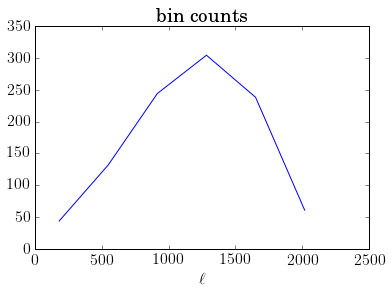

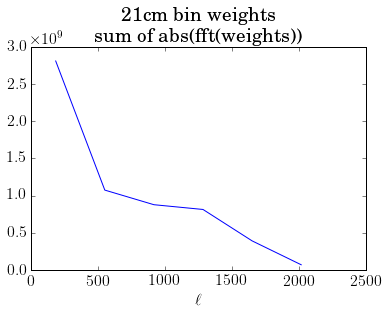

In [64]:
plt.figure()
plt.plot(lbins,bin_counts)
plt.xlabel(r'$\ell$')
plt.title('bin counts')

plt.figure()
plt.plot(lbins,bin_sum_weights)
plt.title('21cm bin weights \n    sum of abs(fft(weights)) ')
plt.xlabel(r'$\ell$')

In [31]:
# ispos = Cl_res_res>0
# isneg = Cl_res_res<0
# plt.plot(lbincenters[ispos],np.sqrt(lbincenters[ispos]**2/(2.*np.pi)*Cl_res_res[ispos]),'bo',linewidth=2)
# plt.plot(lbincenters[isneg],-np.sqrt(lbincenters[isneg]**2/(2.*np.pi)*np.abs(Cl_res_res[isneg])),'bo',linewidth=2)

# plt.ylabel(r'$\Delta(\ell)$ (kJy/sr $\cdot$ K)')
# plt.xlabel(r'$\ell$')